# Домашнее задание. Основы обучения нейронных сетей.

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

In [1]:
'''
Построение полносвязной нейронный сети для классификации цветков ириса с одним
и более скрытым слоем
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
                break
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(sigm_x):
    return (sigm_x)*(1 - (sigm_x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [3]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
# g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'],
                             [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=23)

In [4]:
### Шаг 3. Обучение нейронной сети
# прямое распространие(feed forward)
def run_nn(x, weights):
    # создаем список, в который будем добавлять данные каждого последующего слоя
    # в качестве начального используем входные данные X
    layers = [x]
    for i in range(len(weights)):
        layers.append(sigmoid(np.dot(layers[i], weights[i])))
    return layers

# функция обучения многослойной нейронной сети
# принимает на вход помимо стандартных X, y, learning_rate, epochs_numb(количество итераций)
# также hidden_layer_numb(количество скрытых слоев)
# и neuron_numb(количество нейронов в слое/ях в виде int или массива int)
def learn_nn(x, y, hidden_layer_numb=1, neuron_numb=2, learn_rate=0.05, epochs_numb=1000):
    
    if isinstance(neuron_numb, int):
        neuron_numb = [neuron_numb]

    # Инициализируем матрицы весов для каждого слоя
    syn_weights = []
    for i in range(hidden_layer_numb + 1):
        if i == 0:
            syn_weights.append(2 * np.random.random((4, neuron_numb[i])) - 1)
        elif i == hidden_layer_numb:
            syn_weights.append(2 * np.random.random((neuron_numb[i - 1], 3)) - 1)
        else:
            syn_weights.append(2 * np.random.random((neuron_numb[i - 1], neuron_numb[i])) - 1)

    # создадим список для аккумулирования ошибок на каждой итерации
    errors = []

    for i in range(epochs_numb):
        # проходим по сети, вычисляем преобразованные данные на каждом слое
        layers = run_nn(x, syn_weights)

        # начинаем обратное распространение ошибки, создав списки ошибок
        # и значений коррекций весов последнего слоя
        layers_errors = [y - layers[-1]]
        layers_deltas = [layers_errors[0] * sigmoid_deriv(layers[-1])]

        # производим подсчеты ошибок и значений коррекций весов
        # последущих скрытых слоев до первого
        for i in range(hidden_layer_numb, 0, -1):
            layers_errors.append(layers_deltas[-1].dot(syn_weights[i].T))
            layers_deltas.append(layers_errors[-1] * sigmoid_deriv(layers[i]))
        
        # производим коррекцию матриц весов каждого слоя
        for i in range(hidden_layer_numb + 1):
            syn_weights[i] += layers[i].T.dot(layers_deltas[- i - 1]) * learn_rate
        
        # аккумулируем среднюю ошибку выходного слоя на каждой итерации(эпохе)
        errors.append(np.mean(np.abs(layers_errors[0])))

    return syn_weights, layers, errors

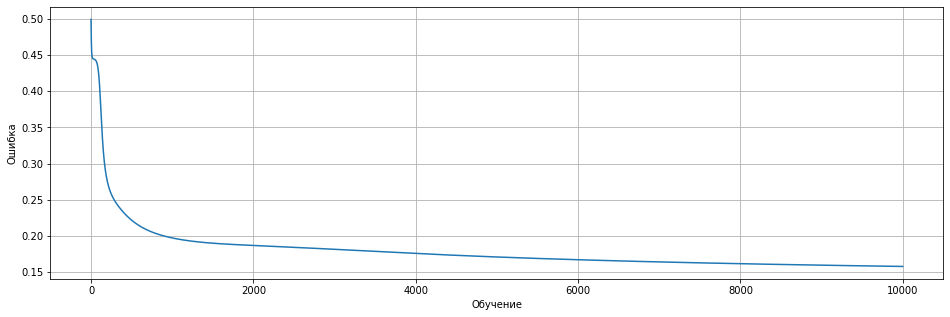

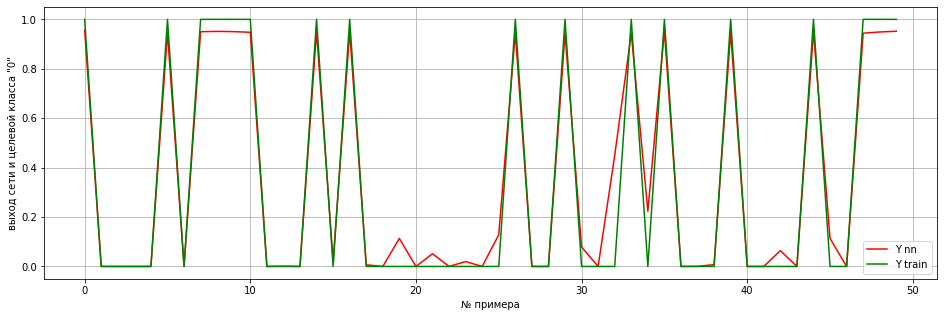

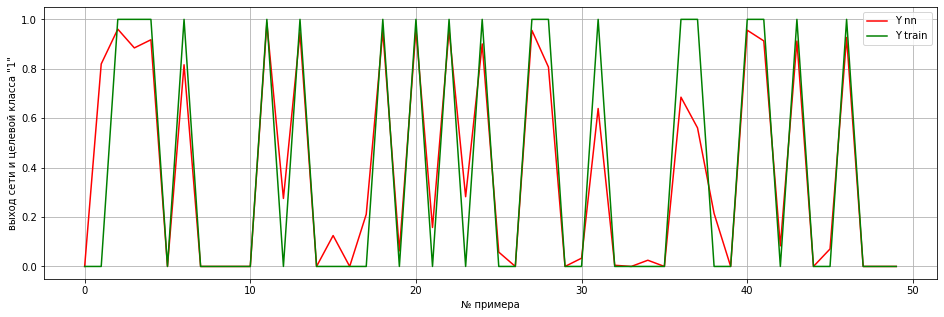

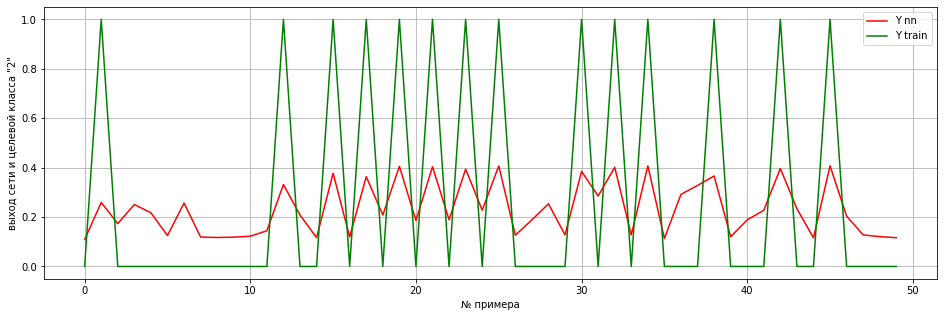

Точность нейронной сети на обучающей выборке: 84.2%


In [5]:
### Шаг 4. Демонстрация полученных результатов на обучающей выборке
learned_weights, layers, errors = learn_nn(X_train,
                                           y_train,
                                           hidden_layer_numb=1,
                                           neuron_numb=2,
                                           learn_rate=0.05,
                                           epochs_numb=10000)
accuracy = (1 - errors[-1]) * 100

# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16, 5))
plt.plot(errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.grid()

N = 50
for i in [0, 1, 2]:
    plt.figure(figsize = (16, 5))
    plt.plot(layers[-1][:N, i], 'r', label = 'Y nn')
    plt.plot(y_train[:N, i],'g', label = 'Y train')
    plt.xlabel('№ примера')
    plt.ylabel(f'выход сети и целевой класса "{i}"')
    plt.legend()
    plt.grid()
plt.show()
        
print("Точность нейронной сети на обучающей выборке: " + str(round(accuracy, 2)) + "%")

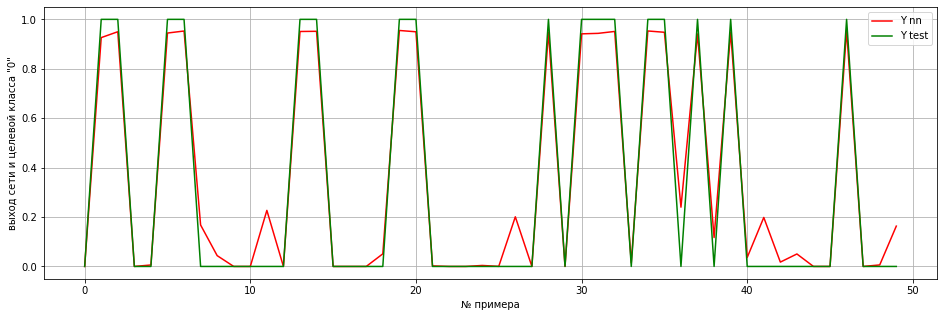

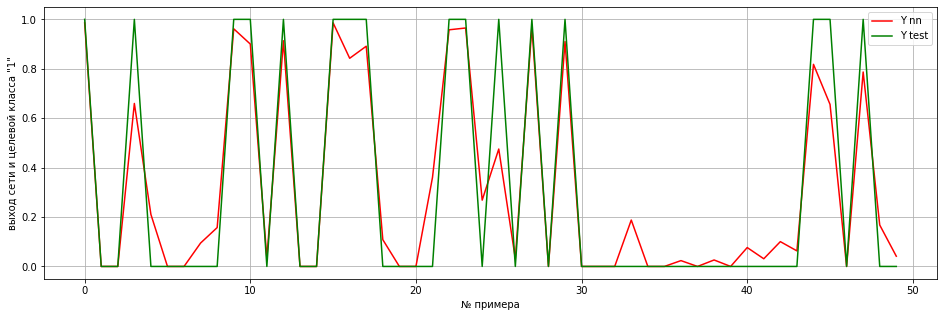

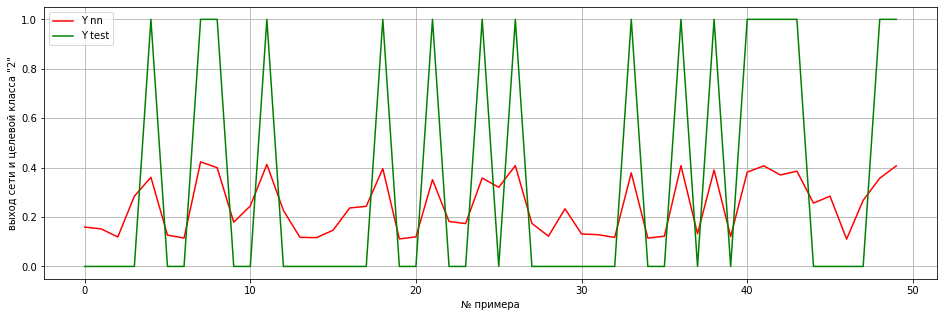

Точность нейронной сети на тестовой выборке: 84.77%


In [6]:
### Шаг 5. Проверка обученной сети на тестовой выборке
layers_t = run_nn(X_test, learned_weights)
error_t = y_test - layers_t[-1]

N = 50
for i in [0, 1, 2]:
    plt.figure(figsize = (16,5))
    plt.plot(layers_t[-1][:N, i], 'r',label = 'Y nn')
    plt.plot(y_test[:N, i],'g', label = 'Y test')
    plt.xlabel('№ примера')
    plt.ylabel(f'выход сети и целевой класса "{i}"')
    plt.grid()
    plt.legend()
plt.show()

# метрика модели
error_t = np.mean(np.abs(error_t))
accuracy_t = (1 - error_t) * 100
print("Точность нейронной сети на тестовой выборке: " + str(round(accuracy_t,2)) + "%")

Как могли заметить, при 2 нейронах скрытого слоя наша сеть крайне неуверенно классифицировала объекты класса "2". Увеличим количество нейронов скрытого слоя до 3.

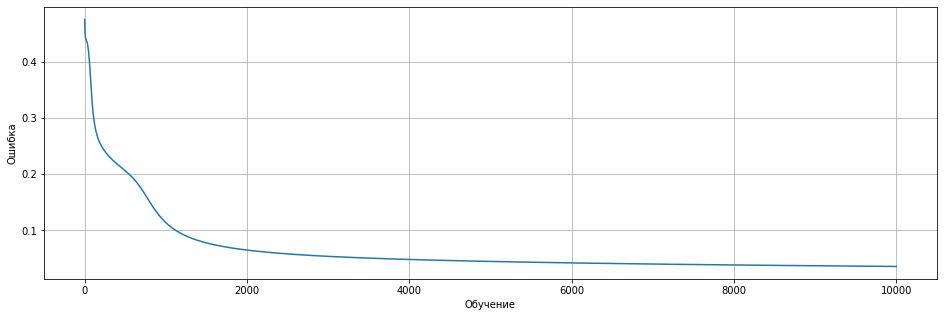

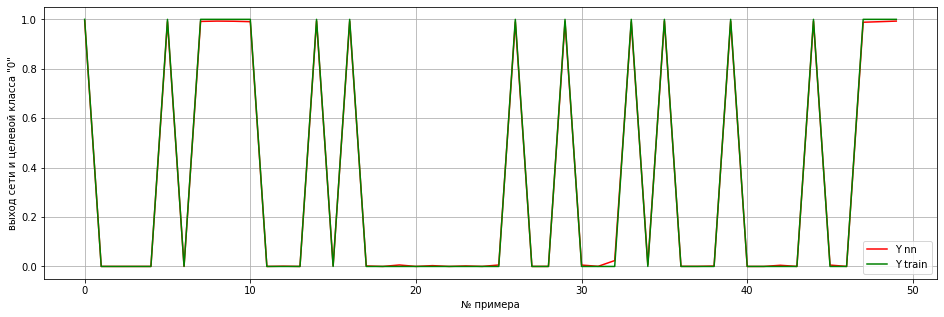

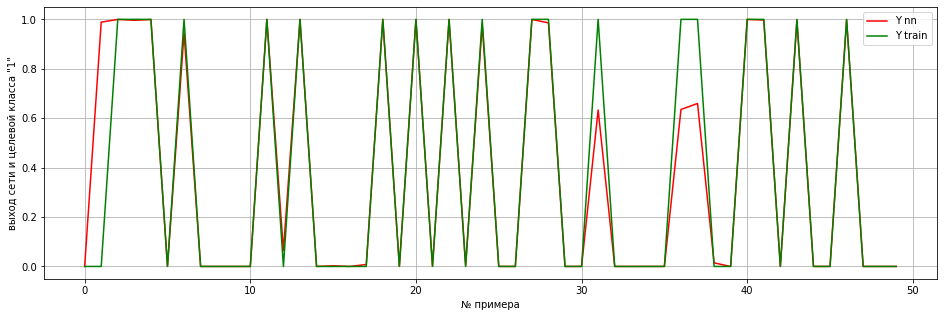

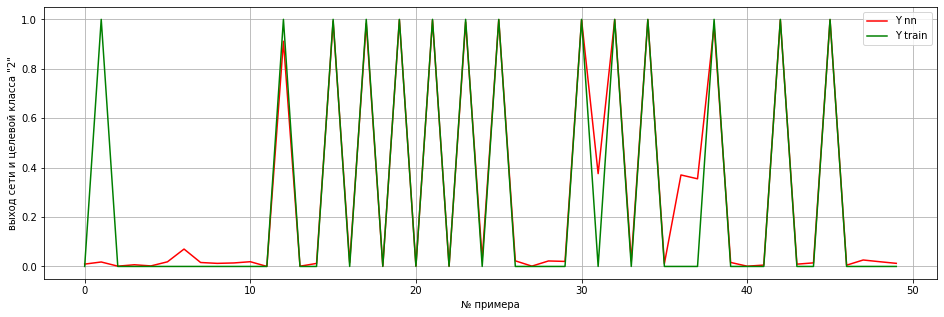

Точность нейронной сети на обучающей выборке: 96.43%


In [7]:
# Обучающая выборка
learned_weights, layers, errors = learn_nn(X_train,
                                           y_train,
                                           hidden_layer_numb=1,
                                           neuron_numb=3,
                                           learn_rate=0.05,
                                           epochs_numb=10000)
accuracy = (1 - errors[-1]) * 100

# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16, 5))
plt.plot(errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.grid()

N = 50
for i in [0, 1, 2]:
    plt.figure(figsize = (16, 5))
    plt.plot(layers[-1][:N, i], 'r', label = 'Y nn')
    plt.plot(y_train[:N, i],'g', label = 'Y train')
    plt.xlabel('№ примера')
    plt.ylabel(f'выход сети и целевой класса "{i}"')
    plt.legend()
    plt.grid()
plt.show()
        
print("Точность нейронной сети на обучающей выборке: " + str(round(accuracy, 2)) + "%")

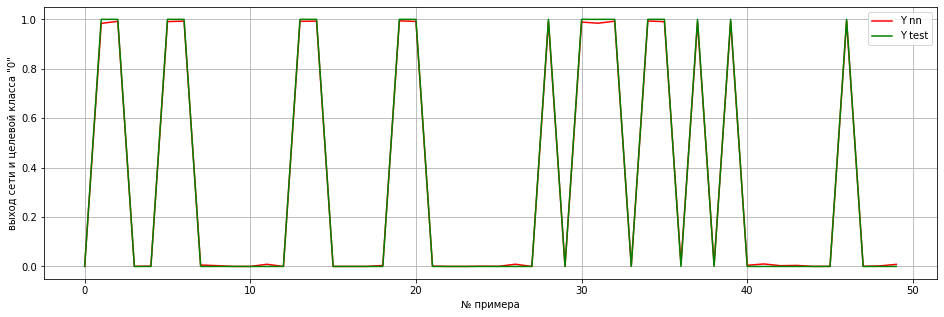

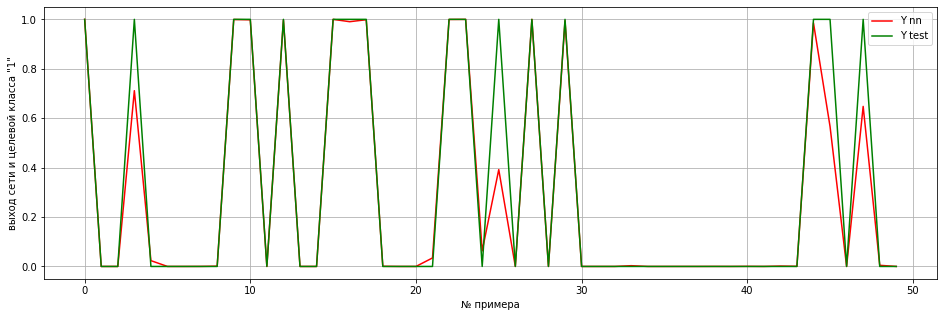

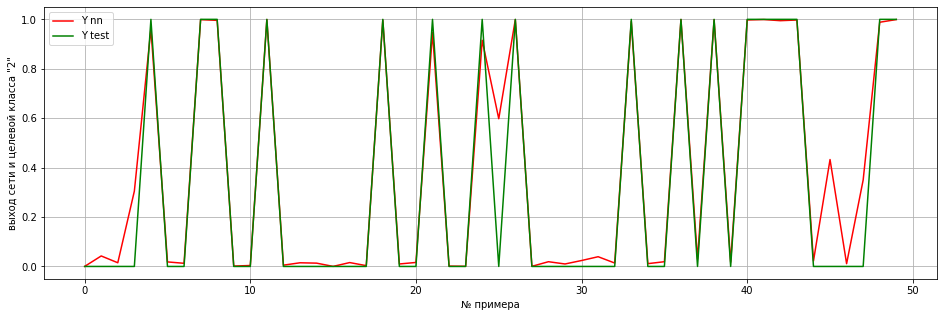

Точность нейронной сети на тестовой выборке: 97.07%


In [8]:
# Тестовая выборка
layers_t = run_nn(X_test, learned_weights)
error_t = y_test - layers_t[-1]

N = 50
for i in [0, 1, 2]:
    plt.figure(figsize = (16,5))
    plt.plot(layers_t[-1][:N, i], 'r',label = 'Y nn')
    plt.plot(y_test[:N, i],'g', label = 'Y test')
    plt.xlabel('№ примера')
    plt.ylabel(f'выход сети и целевой класса "{i}"')
    plt.grid()
    plt.legend()
plt.show()

# метрика модели
error_t = np.mean(np.abs(error_t))
accuracy_t = (1 - error_t) * 100
print("Точность нейронной сети на тестовой выборке: " + str(round(accuracy_t,2)) + "%")

Уже гораздо лучше. Сеть начала уверенно классифицировать объекты всех классов. Дальнейшее увеличение нейронов одного скрытого слоя не дает существенного добавления точности.   
Попробуем при том же количестве нейронов увеличить количество итераций(эпох) обучения до 50000.

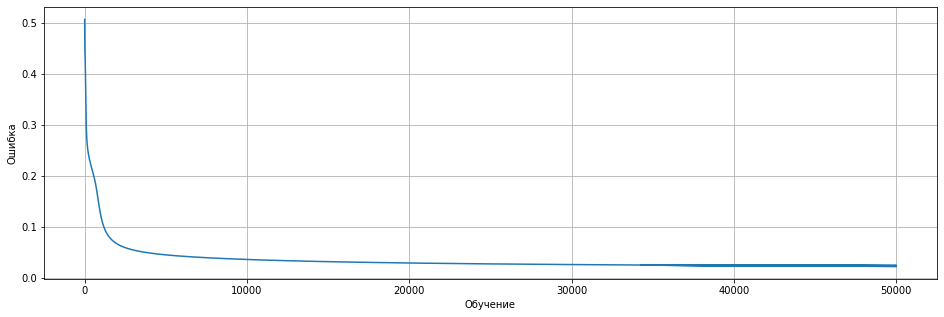

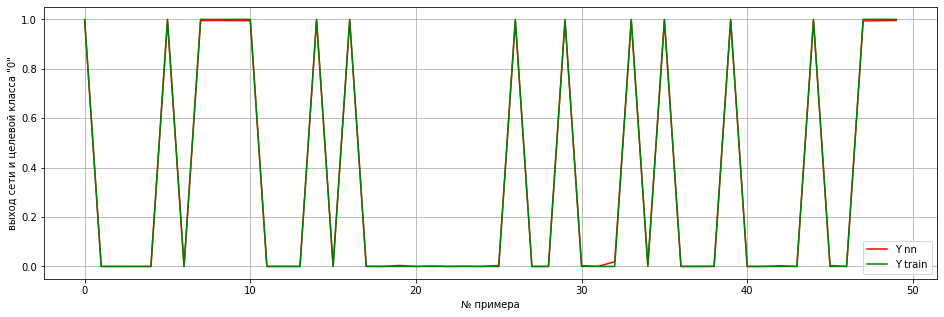

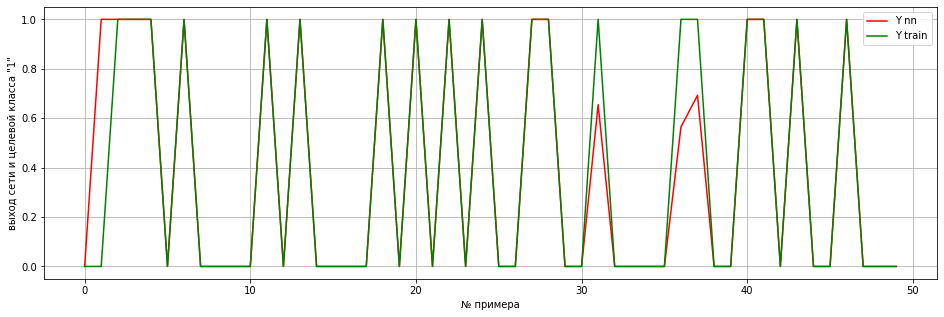

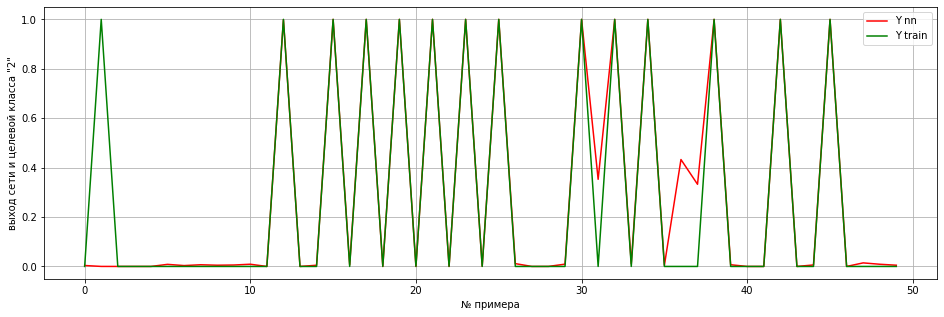

Точность нейронной сети на обучающей выборке: 97.53%


In [9]:
# Обучающая выборка
learned_weights, layers, errors = learn_nn(X_train,
                                           y_train,
                                           hidden_layer_numb=1,
                                           neuron_numb=3,
                                           learn_rate=0.05,
                                           epochs_numb=50000)
accuracy = (1 - errors[-1]) * 100

# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16, 5))
plt.plot(errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.grid()

N = 50
for i in [0, 1, 2]:
    plt.figure(figsize = (16, 5))
    plt.plot(layers[-1][:N, i], 'r', label = 'Y nn')
    plt.plot(y_train[:N, i],'g', label = 'Y train')
    plt.xlabel('№ примера')
    plt.ylabel(f'выход сети и целевой класса "{i}"')
    plt.legend()
    plt.grid()
plt.show()
        
print("Точность нейронной сети на обучающей выборке: " + str(round(accuracy, 2)) + "%")

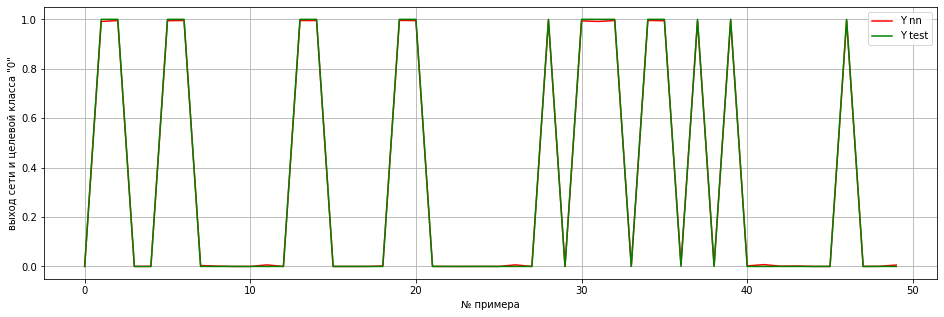

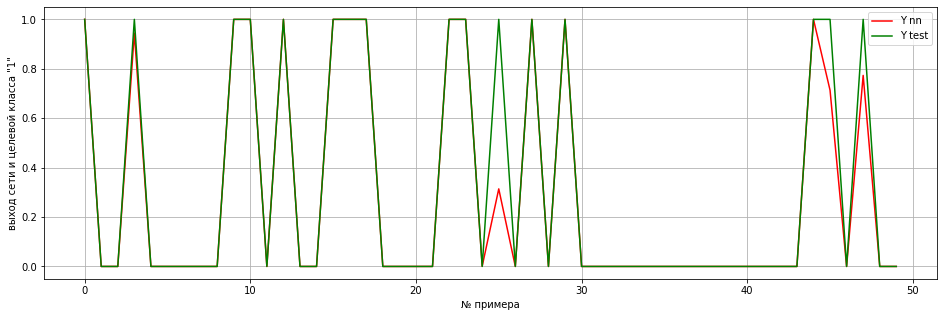

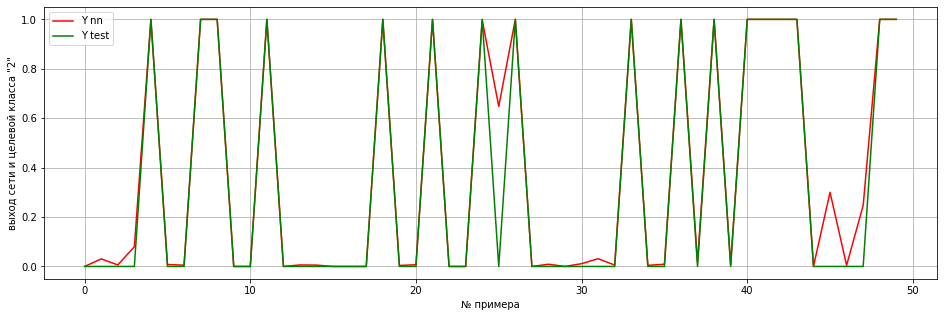

Точность нейронной сети на тестовой выборке: 98.1%


In [10]:
# Тестовая выборка
layers_t = run_nn(X_test, learned_weights)
error_t = y_test - layers_t[-1]

N = 50
for i in [0, 1, 2]:
    plt.figure(figsize = (16,5))
    plt.plot(layers_t[-1][:N, i], 'r',label = 'Y nn')
    plt.plot(y_test[:N, i],'g', label = 'Y test')
    plt.xlabel('№ примера')
    plt.ylabel(f'выход сети и целевой класса "{i}"')
    plt.grid()
    plt.legend()
plt.show()

# метрика модели
error_t = np.mean(np.abs(error_t))
accuracy_t = (1 - error_t) * 100
print("Точность нейронной сети на тестовой выборке: " + str(round(accuracy_t,2)) + "%")

Чего и следовало ожидать: ошибка не значительно, но продолжала падать с увеличением количества итераций.   
Попробуем увеличить количество слоев до 2-х с количеством нейронов 4 и 3 в каждом слое соответственно.

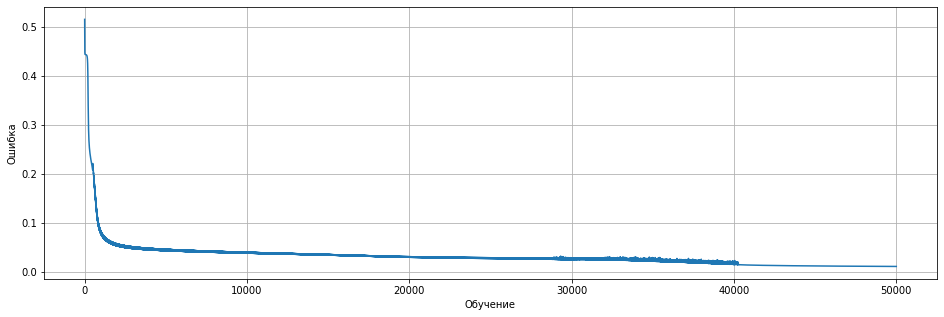

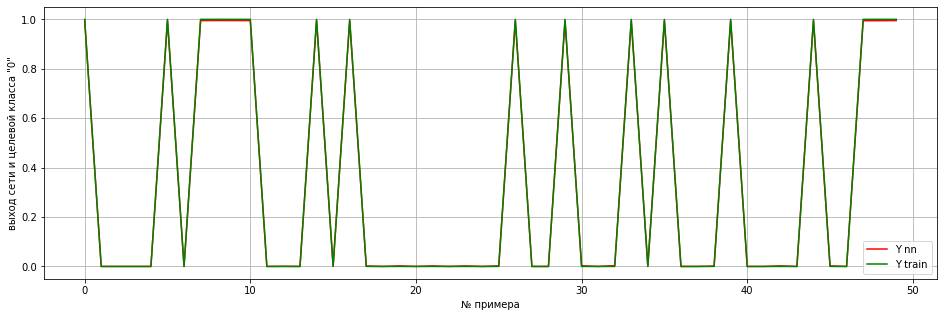

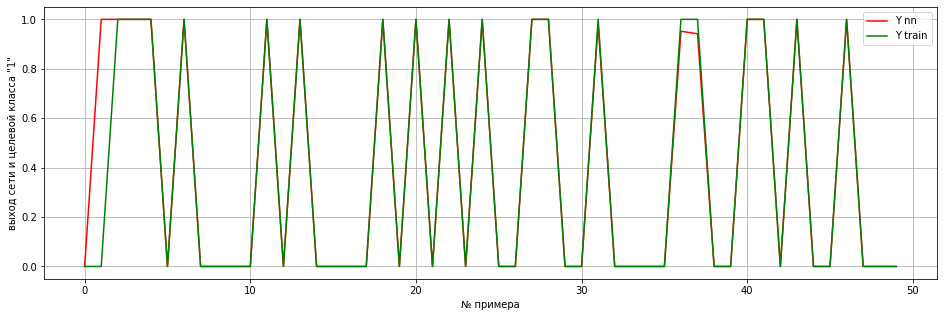

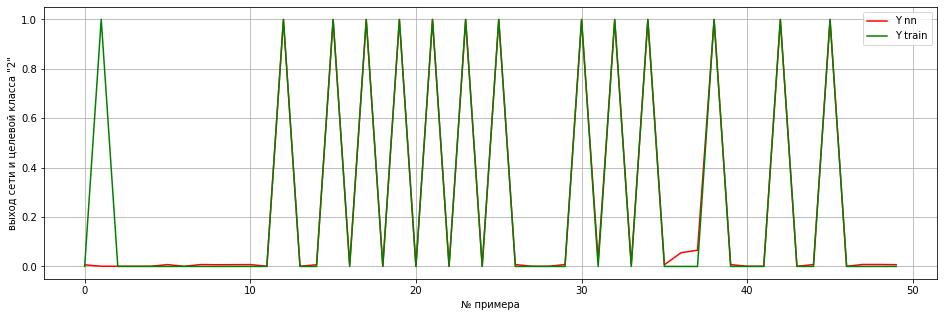

Точность нейронной сети на обучающей выборке: 98.95%


In [11]:
# Обучающая выборка
learned_weights, layers, errors = learn_nn(X_train,
                                           y_train,
                                           hidden_layer_numb=2,
                                           neuron_numb=(4, 3),
                                           learn_rate=0.05,
                                           epochs_numb=50000)
accuracy = (1 - errors[-1]) * 100

# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16, 5))
plt.plot(errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.grid()

N = 50
for i in [0, 1, 2]:
    plt.figure(figsize = (16, 5))
    plt.plot(layers[-1][:N, i], 'r', label = 'Y nn')
    plt.plot(y_train[:N, i],'g', label = 'Y train')
    plt.xlabel('№ примера')
    plt.ylabel(f'выход сети и целевой класса "{i}"')
    plt.legend()
    plt.grid()
plt.show()
        
print("Точность нейронной сети на обучающей выборке: " + str(round(accuracy, 2)) + "%")

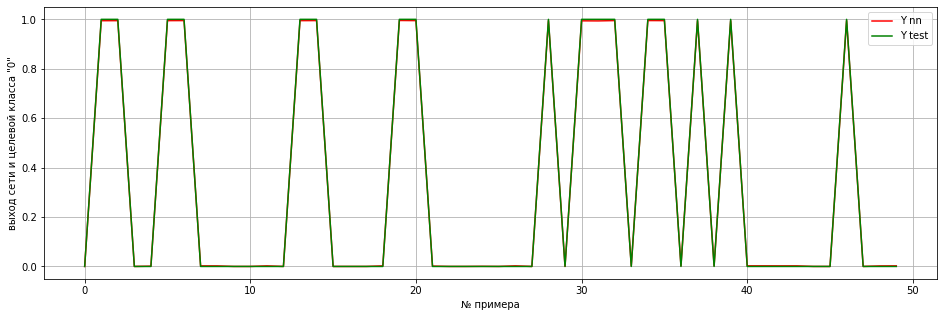

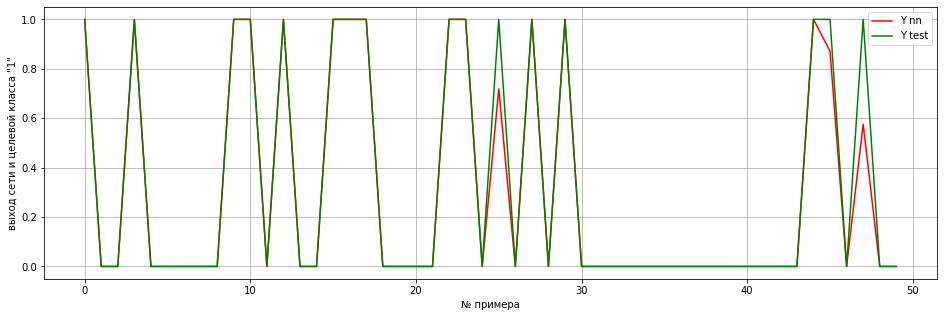

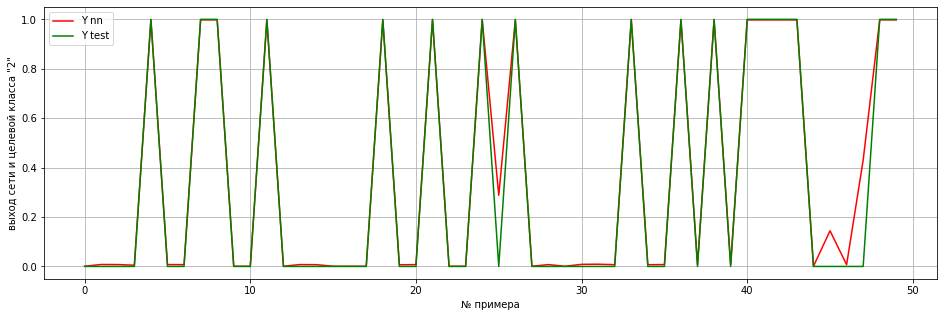

Точность нейронной сети на тестовой выборке: 98.66%


In [12]:
# Тестовая выборка
layers_t = run_nn(X_test, learned_weights)
error_t = y_test - layers_t[-1]

N = 50
for i in [0, 1, 2]:
    plt.figure(figsize = (16,5))
    plt.plot(layers_t[-1][:N, i], 'r',label = 'Y nn')
    plt.plot(y_test[:N, i],'g', label = 'Y test')
    plt.xlabel('№ примера')
    plt.ylabel(f'выход сети и целевой класса "{i}"')
    plt.grid()
    plt.legend()
plt.show()

# метрика модели
error_t = np.mean(np.abs(error_t))
accuracy_t = (1 - error_t) * 100
print("Точность нейронной сети на тестовой выборке: " + str(round(accuracy_t,2)) + "%")

Увеличение количества слоев нейронной сети до 2-х (4 и 3 нейрона в каждом слое) и количестве эпох 50000 дало нам прирост точности.